References :
- https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf
- https://towardsdatascience.com/with-the-emergence-of-social-media-high-quality-of-structured-and-unstructured-information-shared-b16103f8bb2e
- https://pypi.org/project/tweet-preprocessor/
- https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

In [1]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

from wordcloud import WordCloud

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

read zomato and swiggy tweets

In [2]:
import glob
swiggy = pd.DataFrame()
for file_name in glob.glob("swiggy/"+'*.csv'):
    df = pd.read_csv(file_name)
    swiggy = swiggy.append(df)
swiggy['length'] = swiggy['full_text'].apply(len)

/Users/anmol/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
import glob
zomato = pd.DataFrame()
for file_name in glob.glob("zomato/"+'*.csv'):
    df = pd.read_csv(file_name)
    zomato = zomato.append(df)
zomato['length'] = zomato['full_text'].apply(len)

/Users/anmol/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [4]:
print(swiggy.shape)
swiggy = swiggy[~swiggy['full_text'].str.startswith("RT")]
swiggy = swiggy.drop_duplicates(subset=['full_text'], keep="first")
print(swiggy.shape)

(12676, 12)
(5759, 12)


In [5]:
swiggy.sample(100)

,date,favorite_count,followers_count,friends_count,full_text,retweet_count,retweeted,screen_name,tweet_id,user_id,user_mentions,length
388,2019-06-01 15:13:24,0,16,169,@SwiggyCares 42472699846 .... Call me at 95994...,1,NaN,ashishpurbay,1134840375917498368,335090443,['SwiggyCares'],51
390,2019-06-02 15:52:13,0,3,27,@SwiggyCares Your order #42561250316 has been ...,0,NaN,PardeepGulati2,1135212530245103617,533055031,['SwiggyCares'],125
112,2019-07-10 18:20:29,0,0,0,@swiggy_in @SwiggyCares bull shit services. Ma...,0,False,imroufbhat,1149020583448985602,1149012832312156160,"['swiggy_in', 'SwiggyCares']",255
147,2019-06-03 17:05:54,0,8,75,@SwiggyCares You mean next week?,0,NaN,ShreyasSomadder,1135593464798650369,1106978530057830403,['SwiggyCares'],32
156,2019-07-03 17:37:32,0,117,558,@SwiggyCares I haven't received my order no #...,0,False,Shahidvicky,1146473061111062528,157557839,['SwiggyCares'],105
43,2019-06-03 19:10:42,0,19831,2025,@snigdhas95 @swiggy_in Hey Snigdha! We are sor...,0,NaN,SwiggyCares,1135624868974608384,3286336254,"['snigdhas95', 'swiggy_in']",256
290,2019-07-10 16:30:50,0,213,275,@swiggy_in फ्राड कर रहा हैं स्विग्गी कूपन suce...,0,False,arunat35,1148992990318194688,276861011,['swiggy_in'],129
56,2019-06-01 20:06:57,0,1,3,@SwiggyCares Get it checked?? Means you need m...,0,NaN,PankajThacker5,1134914247861854208,922767712601829381,['SwiggyCares'],54
432,2019-07-10 14:40:27,0,24,71,@swiggy_in @SwiggyCares india haar hai mood of...,0,False,olaHoUberr,1148965211086315520,1116262152417886209,"['swiggy_in', 'SwiggyCares']",102
399,2019-07-10 15:05:04,1,11,128,"@SwiggyCares Also just to let you know, the af...",0,False,VijenSanghavi,1148971404945063936,876212691299258368,['SwiggyCares'],186


In [6]:
print(zomato.shape)
zomato = zomato[~zomato['full_text'].str.startswith("RT")]
zomato = zomato.drop_duplicates(subset=['date','full_text'], keep="first")
print(zomato.shape)
zomato.sample(100)

(29372, 12)
(6516, 12)


,date,favorite_count,followers_count,friends_count,full_text,retweet_count,retweeted,screen_name,tweet_id,user_id,user_mentions,length
1031,2019-06-04 14:57:53,1,42,457,@prnv__ @ZomatoIN 😍😍😍😍 this Is called pure love,0,NaN,niteshghadi4,1135923633304375296,793070248249491456,['ZomatoIN'],47
357,2019-06-04 18:13:44,0,233,99,@Zomato @ZomatoIN @zomatocare @zomato\n\nI hav...,0,NaN,itzbsp,1135972920923025408,2914599751,"['Zomato', 'ZomatoIN', 'zomatocare', 'Zomato']",244
673,2019-06-03 10:40:51,0,33,40,@ZomatoIN @swiggy @UberEats_IND hey guys it is...,0,NaN,ankit_musk,1135496563759804416,1873631521,"['ZomatoIN', 'swiggy', 'UberEats_IND']",272
87,2019-06-03 19:44:24,0,135,492,@vigneshprbhu @zomatocare @Zomato @ZomatoIN @z...,0,NaN,AnirudhKkda,1135633350192816129,2237911411,"['vigneshprbhu', 'zomatocare', 'Zomato', 'Zoma...",118
850,2019-06-02 08:18:38,0,53,138,@Zomato @ZomatoIN @zomatocare @deepigoyal see ...,0,NaN,iarihantjain,1135098385222868992,950302222495006720,"['Zomato', 'ZomatoIN', 'zomatocare', 'deepigoy...",102
1116,2019-06-04 14:15:46,1,4237,420,@ZomatoIN This is the least everyone should do...,0,NaN,deepakbiyani,1135913033455116290,84380554,['ZomatoIN'],288
75,2019-06-03 20:01:59,0,17,285,@kageman @ZomatoIN Worthless services ever see...,0,NaN,Dhiraj_Chandra_,1135637774474698752,958805504427307009,"['kageman', 'ZomatoIN']",74
18,2019-07-02 22:39:04,0,11965,42,@cfabhi @ZomatoIN @Zomato Hi Abhishek! That's ...,0,False,zomatocare,1146186555179986945,988362975617601536,"['cfabhi', 'ZomatoIN', 'Zomato']",167
1831,2019-06-04 09:12:17,0,15,99,@mr_shotcut @ZomatoIN What is this,0,NaN,miles_cocktails,1135836660158017537,1064470537924046848,"['mr_shotcut', 'ZomatoIN']",34
954,2019-06-04 15:23:49,0,70,27,@ZomatoIN every order is being packed in a pol...,0,NaN,pnain19,1135930159717003265,3237883736,['ZomatoIN'],210


Check lengths of swiggy and zomato text

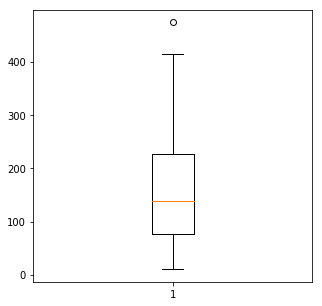

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(swiggy['length'])
plt.show()


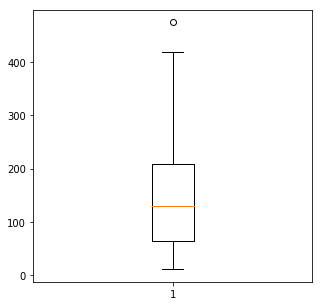

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(zomato['length'])
plt.show()

In [9]:
swiggy['full_text'].head(20)

1     After a long working day, thanks for deliverin...
2     Thank you @swiggy_in for delivering food in mi...
3     @KuffaitMir @swiggy_in Omg I will never use sw...
4     @swiggy_in your customer service sucks, I've b...
5     @SwiggyCares What you mean by apologize is a t...
6     @swiggy_in Sabse bekar company hai meri id nat...
7     @swiggy_in this is the poisionous dal makhani ...
8     @SwiggyCares Oooh really do u want to help. It...
9            Thanx @SwiggyCares https://t.co/stvtDhWqLk
10    @NetflixIndia @Zomato and @swiggy_in  ad on @Y...
11    @SwiggyCares totally discussing first placing ...
12                    @SwiggyCares totally bad services
13    @SwiggyCares I do agree but it's not first tim...
14    @swiggy_in I want my refund because m not gett...
15    @swiggy_in placed order at 11:34 pm. For same ...
16    @swiggy_in Really getting fedup by a billion $...
17    @ZomatoIN @cricketwallah Here is the proof how...
18    @SwiggyCares I received the call from your

<H2>Clean data</H2>

In [10]:
import preprocessor as p

stop_words = set(stopwords.words('english'))
stop_words_list = list(stop_words)

extended_list = []
with open('stop_word_extended.txt') as f:
    extended_list.extend([word for line in f for word in line.split()])

stop_words_list.extend(extended_list)
stop_words_list.extend(['humans', 'water', 'may', 'nice', 'zomato', 'swiggy', 'order', 'food'])
stop_words_list = list(set(stop_words_list))

#remove stop words
def remove_stop_words(text) :
    word_tokens = word_tokenize(text)
    #filter using NLTK library append it to a string
    filtered_tokens = [w for w in word_tokens if not w in stop_words_list]
    return ' '.join(filtered_tokens)

def clean_tweets(text) :
    print(text)
    text = BeautifulSoup(text, 'lxml').get_text()
    try:
        text = text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        text = text
    text = re.sub(r'@[A-Za-z0-9_]+','',text)  #remove all @mention
    text = re.sub('https?://[A-Za-z0-9./]+','', text)  #remove links
    text = re.sub("[^a-zA-Z\s]", "", text)  #remove all #, numbers, etc non alphabets
    text = text.lower().strip() #lowercase and strip
    text = re.sub(' +', ' ', text) #all double spaces with single
    text = remove_stop_words(text)
    #text = p.clean(text)
    print(text + "\n\n")
    return text

In [11]:
#print original text and clean text
swiggy['clean_text'] = swiggy['full_text'].apply(lambda x: clean_tweets(x))

After a long working day, thanks for delivering an inedible food @SwiggyCares @swiggy_in
long working day thanks delivering inedible


Thank you @swiggy_in for delivering food in midnight that too wid 50% discount, I really appreciate 🙌 your delivery boy efforts to get my soup delivered at my doorstep. I am having viral fever🤒 &amp; I can't cook hence ordered from #swiggy 2 am.
Keep up the healthy relationship💯
thank delivering midnight wid discount really appreciate delivery boy efforts soup delivered doorstep viral fever cant cook hence ordered keep healthy relationship


@KuffaitMir @swiggy_in Omg I will never use swiggy in my life .
omg never use life


@swiggy_in your customer service sucks, I've been trying to get my coupon processed for the last 30 minutes but your executive is lazy and unhelpful!! Don't see a point to being your super member, would actually prefer @ZomatoIN from now on! https://t.co/wE20j0ZYzt
customer service sucks ive trying coupon processed last minutes exec




Hello @swiggy_in ur deliver partner isn't picking my call. He is almost 20km away from my home as shown in map. Your chat executive says he will deliver within 5-7 mins. 
Ye chal kya raha hai ? Order kiye hue pura ek ghanta ho gaya hai bhai ? https://t.co/fbhtVvfVMC
hello ur deliver partner isnt picking almost km away home shown map executive says deliver within mins ye chal kya raha hai kiye hue pura ek ghanta ho gaya hai bhai


@SwiggyCares @swiggy_in  Pathetic as usual, Swiggy Sucks.
pathetic usual sucks


@swiggy_in I haven't got my refund yet....it has been 3 days....the outlet cancelled my order saying that the outlet has been closed for now.....bt u guys are nt helpful at all....nobody is here to listen....kindly refund https://t.co/j5s8QSnnVv
havent refund yetit daysthe outlet cancelled saying outlet closed nowbt guys nt helpful allnobody listenkindly refund


Thanks a lot @SwiggyCares @swiggy_in You took my money thrice via different payment methods without delivering the f

trying enlisting restaurant past days received response submitted online form least times used let know issues response


@SwiggyCares Thanks
thanks


@faasos Had a horrible experience with your Kalkaji outlet in Delhi. Ordered using @swiggy_in and these guys kept the delivery boy waiting for an hour and then cancelled, saying that the item I ordered is not there. Wasted mine and his time.
horrible experience kalkaji outlet delhi ordered using guys kept delivery boy waiting hour cancelled saying item ordered wasted mine time


@SwiggyCares This is not Anand
anand


@SwiggyCares Thats nt dne.. i have lost my 2300 and wats d best u can do is 1000 rupees refund
thats nt dne lost wats best rupees refund


@SwiggyCares #42566192932..  Also i just check I'm not getting full payment refund..  So is this new way of earning money.  Forcefully cancel order number deduct more than half amt
check im getting full payment refund way earning money forcefully cancel number deduct half amt


@DhooDala 

delivery agent delivered wrong address agents dumb issue delivering orderpermanently switching least refund money


@Taajkha93588455 @swiggy_in Hhshd
hhshd


@Taajkha93588455 @swiggy_in Jcjjd
jcjjd


@Taajkha93588455 @swiggy_in Hdj u
hdj


@Taajkha93588455 @swiggy_in Jejje
jejje


@Taajkha93588455 @swiggy_in Hdhje
hdhje


@Taajkha93588455 @swiggy_in Hrjjr
hrjjr


@Taajkha93588455 @swiggy_in Hdjdj
hdjdj


@Taajkha93588455 @swiggy_in Hjsje
hjsje


@Taajkha93588455 @swiggy_in Hhsheh
hhsheh


@Taajkha93588455 @swiggy_in Hjdje
hjdje


@Taajkha93588455 @swiggy_in Hushe
hushe


@Taajkha93588455 @swiggy_in Gydhey
gydhey


@Taajkha93588455 @swiggy_in Ghdye
ghdye


@Taajkha93588455 @swiggy_in Hhdje
hhdje


@Taajkha93588455 @swiggy_in Hhhsh
hhhsh


@Taajkha93588455 @swiggy_in Hhdheh
hhdheh


@Taajkha93588455 @swiggy_in Hhshdh
hhshdh


@Taajkha93588455 @swiggy_in Hdghdh
hdghdh


@Taajkha93588455 @swiggy_in Hdjjd
hdjjd


@Taajkha93588455 @swiggy_in Hhdhrh
hhdhrh


@Taajkha93588455 @swiggy_in Ghrjjd

offering refund coupon means wont reflected history mcd orders meaning repeat


@SwiggyCares I also wasted my time. And we all know- all they do in the name of packaging is just dump food in paper bags and wrappers.
wasted time know name packaging dump paper bags wrappers


@SwiggyCares You offered me a coupon of 125. This is inadequate. The refund must be at least 150. I paid extra towards packaging charges. Yet they failed to follow simple cooking etiquette the first time and repeated instructions the second time.
offered coupon inadequate refund must least paid extra towards packaging charges yet failed follow simple cooking etiquette first time repeated instructions second time


@SwiggyCares I wonder how many must have fallen into this sweet trap of yours.
wonder many must fallen sweet trap


@SwiggyCares It was pleasant experience this time. Thank you!
pleasant experience time thank


@SwiggyCares Scrumptious, 7 bungalows. You have ruined my hunger for breakfast.
scrumptious bung

bad service irresponsible respecting time others


@SwiggyCares @swiggy_in And you didn't even take more than a minute to reply that issue has been resolved, hn ? And here I am still waiting for my refund! Very Selfish and Fake company! Late resolution is no resolution.
didnt take minute issue resolved hn waiting refund selfish fake company late resolution resolution


@SwiggyCares @swiggy_in instd of resolving issue, why using cheap tactics.1st order has been spoilt while delievering. cust care suggsted go for replcmnt,thought they ll recover it on tym,but 2nd order takin forevr.Spent 2 hours from the beginning, askd to cancel, but no refund.
instd resolving issue using cheap tacticsst spoilt delievering cust care suggsted go replcmntthought recover tymbut nd takin forevrspent hours beginning askd cancel refund


Hi @jagograhakjago  please look at the following bills by @SwiggyCares @swiggy_in 

This has happened multiple times and probably with multiple customers. On asking the reaso

thank support good service finally know billion dolar company


1/5 #Review on @swiggy_in by chaitanyajayanthi : Worst-Service - https://t.co/LoV4IPRw2Q
review chaitanyajayanthi worstservice


@swiggy_in My past experience is forcing me to not to believe @SwiggyCares .@swiggy_in this will  again going to take 2-3 months without any resolution.
past experience forcing believe going take months without resolution


I was told I would see a coupon of 100 on my account and I don't see that @SwiggyCares
would see coupon account see


@SwiggyCares I have an issue with an order. Order no. 42493782043
I require some assistance as the customer support executive was not very helpful
issue require assistance customer support executive helpful


Love the ease of @getsimpl. pls integrate with @Uber_India and @amazonIN  and @swiggy_in #KeepItSimpl
love ease integrate keepitsimpl


@swiggy_in What to do in this situation? Should someone need to cancel there order or swiggy excutive can help? https://

takes another blue elephant whats name non interactive films advertising kudos kca itcarriesweight


@SwiggyCares I want an definitive action on this and not for future. My order was not only late but was not sealed or packed with any safety tape. P.S your customer support is of no use. https://t.co/IpS6GI0e6x
want definitive future late sealed packed safety tape ps customer support use


@SwiggyCares Ok. Thanks for the info.
Although, considering you are providing the online platform, if your technical team could tweak it such that taxes cannot be overcharged, would be better. Just something to think about. Also, placed the order for burger king. Burgrill lost this one.😋
ok thanks info although considering providing online platform technical team could tweak taxes overcharged would better something think placed burger king burgrill lost


@Help_at_Faasos @SwiggyCares @swiggy_in Below par grievance redressal now https://t.co/zeTGVYnc3U
par grievance redressal


@SwiggyCares I don't kno

hope lassi much shown glass often time raita listed meal thali see less teaspoons


@SwiggyCares Why you give my money back.
give money back


@swiggy_in see the response of your team. Shameful customer service when I asked to take back this pathetic food https://t.co/MJ9LrKWvWc
see response team shameful customer service asked take back pathetic


#SwiggyPOP :
A collection of all terrible food items where one checks in, stares at it, and then closes the app in disgust.

@swiggy_in @SwiggyCares
swiggypop collection terrible items checks stares closes app disgust


@swiggy_in I had ordered upma and poha from Swiggy for Rs. 246 order id# 42440528832. I was delivered stale uncooked food. When I complained I was offered Rs. 50 refund. Please treat you customers with dignity and not offer alms https://t.co/mBH0PHTWaP
ordered upma poha delivered stale uncooked complained offered refund treat customers dignity offer alms


@SwiggyCares I msg u on DM so reply
msg


@SmokingSkills_ @swiggy_in H

ordered litti chokha motherthe reaction opposite thought atta inside uncooked happy


@SwiggyCares Mr Avinash from #swiggycc has solve the issue.
mr avinash swiggycc solve issue


@swiggy_in @SwiggyCares Filled the partner form last month and till today I haven't heard from Swiggy. No representative visited to meet me... Please hurry up the process.
filled partner form last month till today havent heard representative visited meet hurry process


@micromonk_ @swiggy_in It's not a glitch. Because this always happens to me.
glitch always happens


@swiggy_in @SwiggyCares Please please please stop flooding with SMS notifications for a single order. I get more than 5 different SMS notifications for a single order, plus payment notifications from bank extra. Really irritating.
stop flooding sms notifications single different sms notifications single plus payment notifications bank extra really irritating


@sjalan @swiggy_in Hi you can view it on swiggy as Soul Pantry - Andaz Delhi. Deliver

hi rohit talking taken feedback consideration constantly striving improve quality service thank hope see soon


@SwiggyCares Still waiting as 48 hours is over? MO refund has been given and i see no money coming in my account.
waiting hours mo refund given see money coming account


@SwiggyCares By when can I expect a resolution?
expect resolution


@SwiggyCares Got a callback from Wilma from your escalations team. Thanks for the resolution and hoping something like this won't happen again.
callback wilma escalations team thanks resolution hoping something wont happen


@SwiggyCares It takes around 20 days to correct spellings n still it’s not perfect. I really don’t mind with dis all jus mark off me from your list. Thank you https://t.co/dBLLdAl0A3
takes around days correct spellings n perfect really mind dis jus mark list thank


@Kenneth @swiggy_in @Zomato Similar but worse experience with @uber

Had forgot my phone in the cab. Perfect time to realize that they don't let you call the

yeah okay


@SwiggyCares Waiting for call.
I hope you gonna call before last ordering time.
waiting hope gon na last ordering time


@SwiggyCares @vineetmehra1 Yes they say they don't have control over restaurant hence cannot help
yes say control restaurant hence help


@swiggy_in has done this twice to me. https://t.co/FycYKh3OmA
done twice


@SwiggyCares Please resolve it as fast you can.
I'm not going to sleep hungry bcoz of  you.
resolve fast im going sleep hungry bcoz


@SwiggyCares @swiggy_in and/or  @dominos_india Please, When are you arriving in  Sitamarhi, Bihar 
Tired of ordering such bad pizza and pathetic delivery(2hrs and 20 minutes) 🙄 from local shops and vendors https://t.co/xzysm5Kmts
andor arriving sitamarhi bihar tired ordering bad pathetic deliveryhrs minutes local shops vendors


@SwiggyCares I am trying to order a food from your app when I am selecting the dish  it is not getting selected . I wanted to order from the same restaurant in different branch
trying app s

ordered sweets raita instead reason avoid ordering nothing regarding useless coupon rupees minimum delivery charge rupees little bettr


@zomatocare @Zomato @ZomatoIN @ZomatoIN 
Ur chat support team is too busy to connect,when someone is available,they r busy with their own work nd not even responding to my concern.He might be busy in  whatsapp😏.Chat support getting too worst
It might b tym to switch to  @swiggy_in 
@zomatocare @SwiggyCares https://t.co/KMmaQc1BQF
ur support team busy connectwhen someone availablethey r busy work nd responding concernhe might busy whatsappchat support getting worst might b tym switch


@SwiggyCares @swiggy_in worst app...cheaters,complete fraud...firstly they missed the item and then refused to refund...what to do..stuck in between the liars...
worst appcheaterscomplete fraudfirstly missed item refused refundwhat dostuck liars


@swiggy_in worst app...cheaters,complete fraud...firstly they missed the item and then refused to refund...what to do..stuck 

amidst incessant rain mumbai thing stands delivery mechanism deliveries groceries ecom products r getting delivered despite bad weather guys hv rockstars ur delivery team respect


@SwiggyCares @swiggy_in @MasterSwami @mvd_india @NayyarMayank @parthaabosu @rahulhuria In fact it's your prerogative to intervene if, as claimed by you, someone is using your website to malign you..It is you who are selling at more than restaurants and when people are finding it out you are blaming restaurants. You are not only thieves &amp; cheaters but liars as well
fact prerogative intervene claimed someone using website malign youit selling restaurants people finding blaming restaurants thieves cheaters liars well


DM sent ... now resolve it @SwiggyCares
sent resolve


Both Swiggy and Dominos customer services are living upto their rotten reputation. 👏👏
Order ID #45065995221
 @swiggy_in @SwiggyCares @dominos_india
dominos customer services living upto rotten reputation


@SwiggyCares I would be happy to

back


@SwiggyCares Thanks for the swift resolution of the matter by Sam from @SwiggyCares
thanks swift resolution matter sam


@swiggy_in https://t.co/Wcabo1qgJL



@swiggy_in it is very kind request to all swiggy customer don't take the service of swiggy because they deducted the money two for a single order. Because I am facing the same problem. 

Regards
Varun kumar
8178877455 https://t.co/GkbyEwD0ph
kind request customer take service deducted money two single facing problem regards varun kumar


@SwiggyCares I just asked the policy
asked policy


@chins2wit @swiggy_in typical reply for support.
typical support


I don’t know about you’ll but the ad I love the most is the @swiggy_in ad - #quesadilla and #lasagne #toogood - also the #ladoo one #win
know youll ad love ad quesadilla lasagne toogood ladoo win


@aniruddhargk @swiggy_in @SwiggyCares Very True..
true


@swiggy_in @SwiggyCares I had problem with order, order didnt went through and money got deducted but customer care don'

common daysthey customerseven super members whats use f


@SwiggyCares Whatever suits you man, night Aravind!
whatever suits man night aravind


@deepali91683347 @swiggy_in @SwiggyCares @WeAreSwiggy File a case for attempt to murder..
file case attempt murder


@deepali91683347 @swiggy_in @SwiggyCares @WeAreSwiggy https://t.co/OGxpROlMZm



An #app that helps deliver home-cooked meals every day. @swiggy_in launches #SwiggyDaily https://t.co/CckeEShUrh … https://t.co/bZbCAr1fZ8
app helps deliver homecooked meals every day launches swiggydaily


@SwiggyCares It's on Twitter 'Promoted'
twitter promoted


An #app that helps deliver home-cooked meals every day. @swiggy_in launches #SwiggyDaily https://t.co/JBvpE12O11 https://t.co/3F0KZp1pin
app helps deliver homecooked meals every day launches swiggydaily


@SwiggyCares @SwiggyCares I would love to help the best food teach Delivery Company here is KSA. Please reach me out +966560369539
would love help best teach delivery company ksa reach



use words


@SwiggyCares Do not rotate things round Please tell me what you are giving me better for this
rotate things round tell giving better


A really thought through campaign by @swiggy_in in terms of idea but operation just messed up big time. Got 7 different SMSes from a same campaign. 
@SwiggyCares
#swiggy #CustomerExperience #spam https://t.co/Y9blrcc7Cq
really thought campaign terms idea operation messed big time different smses campaign customerexperience spam


@SwiggyCares @swiggy_in @WeAreSwiggy When you order something less than 99, then these notifications come , in the window where you apply coupons, I think this would do the trick for you , right?
something less notifications come window apply coupons think would trick right


@SwiggyCares I want resolution, yesterday I had to accept the order because I was left with no other option. You people just making us fool with the incomplete information
want resolution yesterday accept left option people making fool incomple

In [12]:
#print original text and clean text
zomato['clean_text'] = zomato['full_text'].apply(lambda x: clean_tweets(x))

@zomatocare @ZomatoIN Order No 2019229017 this is the order Id that I have.
This is the first time I am having this kind of trouble with Zomato have never faced the issue like this even you guys can check the chat I’ve always appreciate the good food, do look into it.
Hope you understand
Kuldeep Singh
first time kind trouble never faced issue guys check ive always appreciate good look hope kuldeep singh


When I asked them where it is articulated that dishes more than Rs.1k is not available under gold offer. They openly said, it is not articulated anywhere. Meaning @ZomatoIN is cheating in daylight by not giving me the gold membership privilege which I bought for Rs.1300. -Part 5
asked articulated dishes rsk available gold offer openly said articulated anywhere meaning cheating daylight giving gold membership privilege bought part


@idk_umf @ZomatoIN Hi There! We apologize for the goof up. Please share the order ID so that we could get this checked for you. 🂡SS
hi apologize goof could

oh btw ordered credit given last messee days back


@SatyamK74195910 @ZomatoIN Hey Satyam! We are here for you. Mind sharing the order number so that we can have this checked from our end.
^BG
hey satyam mind sharing number checked end bg


@buddhifree @ZomatoIN Hey Rzchit! Never wanted to serve you like that. Mind sharing the order number so that we can have this checked from our end.
^BG
hey rzchit never wanted serve mind sharing number checked end bg


@ayush987goyal @swiggy_in @ZomatoIN @UberEats_IND Pls try n avoid using single use plastics such as water bottles. @SwiggyCares plastics are causing enough n more damage to the environment pls think twice before introducing these.
try n avoid using single use plastics bottles plastics causing enough n damage environment think twice introducing


Good job!  @ZomatoIN Asking to me elaborate on my concern. Trust this helps. https://t.co/4vqrjJY0N2
good job asking elaborate concern trust helps


@ZomatoIN @zomatocare @Zomato

Is Zomato in

uber eats use karo match wali offer hogi


@ZomatoIN order id 1710506858 all burnt paranthas were non eatable...pl refund entire order amount to source a/c @zomatocare @NupurSGarg
burnt paranthas non eatablepl refund entire amount source ac


@azharshaikh000 @ZomatoIN @Zomato Hey Azhar! Never wanted to disappoint you. We are getting this checked and will get in touch with you shortly.
^BG
hey azhar never wanted disappoint getting checked touch shortly bg


@Taeionysus @ZomatoIN @Zomato Zomato is shiz use food panda
shiz use panda


Hey @swiggy_in , @ZomatoIN and @UberEats_IND ! I have a small suggestion for you. It would be great if you could ask your restaurants to include packed drinking water in their menus. There are only a limited few restaurants that have water and it's hard to find when in need!
hey small suggestion would great could ask restaurants include packed drinking menus limited restaurants hard find need


@munshiji95 @MODIfiedVikas @Olacabs @Uber_India @swiggy_in @Zoma

idea guys


@Zomato @ZomatoIN @zomatocare Are you running a scam? You're not refunding amount of failed transactions. Even after several followups. Something fishy is going on surely.
running scam youre refunding amount failed transactions several followups something fishy going surely


@zomatocare Did you checked?
checked


@ZomatoIN Why you being so Joey? But hey I like Joey.
joey hey joey


@Zomato  @zomatocare  😡😡 check my tweet for order id https://t.co/4AXJHJSx1I
check tweet


@ZomatoIN still waiting....whats your POA on this???
waitingwhats poa


@zomatocare Order no: 1358596803 Oder confirmed at 9:32pm and delivered at 11:15pm, the restaurant guys are liers they kept on saying it was on the way till 1 hr
oder confirmed delivered restaurant guys liers kept saying way till hr


❤️🧡💛💚💙💜
@ZomatoIN @Zomato 
Better food for more people. Unconditionally. https://t.co/oHuBDYPM9o
better people unconditionally


@ZomatoIN @ZomatoIN @Zomato @zomatocare @ZomatoGold 

Dear Zomato Team Than

need response earliest telling spare guys social media starting today update guys next minutes


@zomatocare @Zomato @ZomatoIN Where is the solution Guys ? You guys are only giving commitments https://t.co/erQ4bt9ap9
solution guys guys giving commitments


@zomatocare Extremely poor customer support. I still have not received my order because the valet dropped the food. No response from Zomato customer care. Poor service is becoming USP of Zomato. Order No. 1398013292
extremely poor customer support received valet dropped response customer care poor service becoming usp


@deepigoyal Sir, even after getting confirmation from your Team I have not received the Payout from Zomato ... How do I run my business ? It's been 2 payouts now .

Rest # 18747875

@zomatocare @Zomato @ZomatoIN https://t.co/0TjfMQcO15 https://t.co/vzyJoIgWO4
sir getting confirmation team received payout run business payouts rest


@zomatocare I need a response at the earliest. I am telling you, I will not spare you g


@zomatocare 1459906712



@zomatocare @ZomatoIN 1459906712



@zomatocare @Zomato @faasos 

I didn't get my refund it's more than 10 days.
didnt refund days


@ZomatoIN If he would have at least had a logo on him, I would have approached him. The customer care is saying they cannot refund and i need to place a fresh order! So,i just donated my money for nothing expect wasting couple of hours on anxiety and frustration.I'm disappointed.
would least logo would approached customer care saying refund need place fresh soi donated money nothing expect wasting couple hours anxiety frustrationim disappointed


@ZomatoIN I was able to get a hold of him over the phone, and his response was he cant reach me, and if I hv anything, i shuld take care of it with zomato customer care. He told me that he was in a civil dress with no signs of whatsoever that he belongs to zomato delvery guy
able hold phone response cant reach hv anything shuld take care customer care civil dress signs whatsoever belong

support highly doubt guys first incident hope would initiated basic check


@zomatocare hey...any response,,?
heyany response


@dipraman1611 @ZomatoIN Hey Dipraman! That seems really awful. Please help us with the 10-digit order number and we will get this checked from our end.
^BG
hey dipraman seems really awful help digit number checked end bg


@NehaNair @ZomatoIN Hey Neha! That seems like a temporary issue in the area, as all the restaurants are shut down due to som unusual circumstances. Don't worry, we will be back soon.
^BG
hey neha seems temporary issue area restaurants shut due som unusual circumstances worry back soon bg


Sharing the screenshots of the revert received from @zomatocare . They are refusing to refund and also not getting the order delivered which is still present with the delivery boy. https://t.co/AvxQGO3AkO
sharing screenshots revert received refusing refund getting delivered present delivery boy


@Khan_umair_ @ZomatoIN @Zomato Hey Umair! Apologies for the 

zomatoindia


@zomatocare  uncooked food . And worst quality food. Plus my message is not getting delivered in support chat https://t.co/j8b70b4eRh
uncooked worst quality plus message getting delivered support


@zomatocare it's 7th consecutive time zomato fooled me.. worst food . Worst delivery app. Uncooked food delivered fed up with zomato. 
#zomatopleasedie
th consecutive time fooled worst worst delivery app uncooked delivered fed zomatopleasedie


@zomatocare How long will this solution be? Still not refunded.
long solution refunded


No Reply. 
Still how many month you want to reply.
Not happy with attitude.
@Zomato @zomatocare @ZomatoIN @ZomatoGold 
But to switch to other service provider i.e. @swiggy_in @SwiggyCares @foodpandaIndia @UberEats_IND https://t.co/zq3DIDxErR
many month want happy attitude switch service provider ie


@Zomato @ZomatoIN @zomatocare guys aapko faraq padtha hai.
guys aapko faraq padtha hai


@Zomato @ZomatoIN @zomatocare Why are you spamming me guys? I d

thing happened nd june ordering dinner waste


@tejvardhan_c @zomatocare Faasos are looters actually!!
faasos looters actually


@zomatocare @ankita_umbre @ZomatoIN @Zomato Same is done with me .They are not able to handle customers.
done able handle customers


@Zomato @ZomatoIN @zomatocare  zomato stared looting people by unethical  way. 
Sorry to say but one of worst customer care service experience. Need clarification  on this. https://t.co/YjPv48qQmH
stared looting people unethical way sorry say worst customer care service experience need clarification


@zomatocare @Zomato Hi @FinMinIndia,
Zomato has been selling customers' data to its partners.
Now they have been contacting me without my consent.
Do you have a department to lodge a complaint against @Zomato and the partners?

@BOX8_in @MojoPizzas https://t.co/yggOmfmMzA
hi selling customers data partners contacting without consent department lodge complaint partners


@zomatocare You always say that but my order is ruined every 

@zomatocare @Zomato Still no reply from your side.. highly unprofessional.. My family and I are boycotting zomato. Cheers 🥂
side highly unprofessional family boycotting cheers


@zomatocare @zomatocare see this is what i was talking https://t.co/ZZbssWK6H3 support
see talking support


@rATHOREsURESH @ZomatoIN Hi Suresh! We take road safety very seriously and instruct our delivery partners to follow all the traffic rules. If you have noticed anything untoward, Feel free to DM us details (bike plate number, etc) so that we can take immediate actions. ^SS
hi suresh take road safety seriously instruct delivery partners follow traffic rules noticed anything untoward feel free details bike plate number etc take immediate actions ss


@zomatocare @Zomato @ZomatoIN No one is listening
listening


@Poojaaltekar1 @ZomatoIN Hi Pooja! That doesn’t look like an ideal ordering experience. Mind sharing your 10 digit order id and we will get checked this from our end for you. ^SS
hi pooja doesnt look

way behaves complain bad account blocked reason disappointed lkcom


@zomatocare @ZomatoIN @Zomato @jagograhakjago @narendramodi 
This is the way zomato behaves if i complain against bad food.
My account has been blocked for no reason.
I am so disappointed
lk7275543340@gmail.com https://t.co/BybJD0EbCh
way behaves complain bad account blocked reason disappointed lkcom


@zomatocare 1301827992



@zomatocare @ZomatoIN @Zomato @jagograhakjago @narendramodi 
This is the way zomato behaves if i complain against bad food.
My account has been blocked for no reason.
I am so disappointed
lk7275543340@gmail.com
way behaves complain bad account blocked reason disappointed lkcom


@zomatocare I spoke to ur support they said they will refund the money. Just request you to imagine what would have happened if I swallowed one of the pins. How my family would have to pay for this.. Just pls be careful about the public health standards
spoke ur support said refund money request imagine would happened s

ordered waiting hr refund message saying sorry inconvenience sorry word looking premium customer treated ref number


@zomatocare @ZomatoIN @Zomato Zomato team,
Will there be any help? I have applied code Cricket on my order but not able to answer the three prediction questions.
team help applied code cricket able answer three prediction questions


@zomatocare What's wrong zomato. Day by day going worse.
I ordered a biryani using zomato at 1.20 pm. Order has been accepted &amp; after waiting 1.5 hours they reported restaurant unable to fulfill your order. Can someone contact me in an urgent basis. https://t.co/U35Ee6wh5J
whats wrong day day going worse ordered using accepted waiting hours reported restaurant unable fulfill someone contact urgent basis


@zomatocare @deepigoyal @ZomatoIN Ary, you check that or??
ary check


@ZomatoIN @deepigoyal Had a less than ordinary experience with my recent order. I have tried reasoning with your cust. suprt but to no avail. It seems you guys are 

hell support isnt working need otherwise use kindly take priority


@zomatocare Pls check dm.. I have already shared my number
check already shared number


@dhrumilgala @swiggy_in Sorry to hear you had to go through this much shit, man. I've had a lot of terrible experiences with @swiggy_in too, they revel in the fact that most of us have to use their services in spite of the pathetic quality. I mostly order from @ZomatoIN now.
sorry hear go much shit man ive lot terrible experiences revel fact use services spite pathetic quality mostly


Any updates @zomatocare @deepigoyal
updates


@zomatocare Hell @zomatocare what's the point of that. See the above chats. U ppl are just irritating. If you really wanna solve then do what you said in the chats earlier. It'd be helpful. Just replying to the tweets and doing nothing internally.
hell whats point see chats ppl irritating really wan na solve said chats earlier itd helpful replying tweets nothing internally


@zomatocare @ZomatoIN @Zomato 

update never seen third class delivery app irony regular foodie getting account blocked sure went wrong telling


@zomatocare @ZomatoIN orderes for a cake.. And got something like this.. Then was promised refund and told it is initiated 1 week ago n now they blocked my account.. No refund nothing.. Useless guys.. I wish i could abuse on this platform https://t.co/DzAlWs1Axr
orderes cake something promised refund initiated week ago n blocked account refund nothing useless guys wish could abuse platform


@ZomatoIN @zomatocare also this https://t.co/nqaRr6IwI1



@ZomatoIN @zomatocare so many tweets and no response from ur end.. Highly shaame less guys https://t.co/58YkAKRYUd
many tweets response ur end highly shaame less guys


@zomatocare @ermohit Dude what abt my issue guys are simply ignoring me
dude abt issue guys simply ignoring


@zomatocare am fedup of zomato.. U guys havent responded in, 7days..read all the dm but no call back. This is my 50th tweet for the concern
fedup guys ha

complaint well done team shameless third class service agein bad experience


@zomatocare So now what????  Still awaiting ur response???? 

What now??  Where's my refund a and your apology (fake)??
awaiting ur response wheres refund apology fake


@zomatocare Food delivered after 1 hr 15 mins
delivered hr mins


@ZomatoIN 

Pathetic Service is delivering by zomato.ordered food on 10:29pm got delivery at 11:20. delivery boy marked delivered in between but when it was really delivered to me ice cream got melted and waisted...no response even on chat. Should shut down this app https://t.co/cyApunqiH4
pathetic service delivering zomatoordered delivery delivery boy marked delivered really delivered ice cream melted waistedno response shut app


@zomatocare perfect...u guys have the balls to cancel the order now..
perfectu guys balls cancel


@zomatocare Hello @zomatocare I have send you my alternate number also but didn't receive any response yet!!
hello send alternate number didnt receive 

another customer unfriendly service probider often misleads people sticks version ignoring customers large number quits compel correct


@zomatocare Order id 1124539166



@zomatocare is ignored all my images.. I shall be complaining about stale food being sent by zomato.. @SwiggyCares i used feel zomato is better.. Swiggy u get a new customer here
ignored images shall complaining stale sent used feel better customer


Make your Monday nicer!
Order now @zomatoin @swiggyindia
@ubereats_ind @foodpandaindia
 #foodlove #enjoy #foodgasm #foodheaven #foodlovers #foodie  #foodporn #foodgasm #foody  #cuisine #tasty #foodstagram #foodaholic #foodbeast  #veg #nonveg #buzzfeastfood #foodoptions https://t.co/K8O2qQk7jC
make monday nicer foodlove enjoy foodgasm foodheaven foodlovers foodie foodporn foodgasm foody cuisine tasty foodstagram foodaholic foodbeast veg nonveg buzzfeastfood foodoptions


@zomatocare @zomatocare @Zomato @ZomatoIN 
From last 1hr no one responding to chat also.
This shows zo

supposed follow zomatos mistake refund form credits directly bank account


@zomatocare @Zomato @ZomatoIN @swiggy_in @SwiggyCares My order id is 1302782007



@ZomatoIN My order number - 1512865527
number


@zomatocare Waiting for the same
waiting


Hi Zomato Team ! Now days  the zomato customer service was very pathetic in customer  service, if we chat them for a resolution they will asked to wait for 24 to 48 hrs. @ZomatoIN @zomatocare @Zomato @deepigoyal
hi team days customer service pathetic customer service resolution asked wait hrs


@PawanLahoti16 @ZomatoIN @Zomato Hi Pawan! That is not how we roll! Please help us out with your registered mobile number and we will reach out to help you out. ~Ary
hi pawan roll help registered mobile number reach help ary


@zomatocare Consumer forum complaint no 1356701.
consumer forum complaint


I had placed the order from @ZomatoIN on 1st June midnight. It showed the dish but when i placed the order n made the payment, the restaurant person ca

mujhe apna refund jaldi chahiye


@zomatocare Order #1631161679



Pathetic service of @Zomato  @ZomatoIN even with their regular customers and still no response of mail after more than 2 days.
Disappointments..
pathetic service regular customers response days disappointments


#Zomatohatao #WorstZomatoIndia #zomatochorhai #Zomatofraud #Uninstallzomato @zomatocare @ZomatoIN 
 
 @zoink
zomatohatao worstzomatoindia zomatochorhai zomatofraud uninstallzomato


Is that a joke to you @Zomato @zomatocare ? Such kind of negligence should be punishable to both the restaurant and Zomato. @AhmedabadPolice should also take note. #HBDFatherOfCorruption #HBDKalaignar96 https://t.co/Ucw3AE2YIu
joke kind negligence punishable restaurant take note hbdfatherofcorruption hbdkalaignar


@Samir_Pillai @Zomato Is that a joke to you @Zomato @zomatocare ? Such kind of negligence should be punishable to both the restaurant and Zomato. @AhmedabadPolice should also take note. #HBDFatherOfCorruption #HBDKalaignar

hi rahul thats wanted serve mind sharing checked ss


@ZomatoIN  nobody from your Coustomer care is replying me😡 order no-1566853314, it’s been more than an hour
nobody coustomer care replying hour


@zomatocare its very bad way to treat customer ...not responding to customer for bad service is not good idea
bad way treat customer responding customer bad service good idea


@zomatocare @Zomato I ordered a rice bowl with curry and rice ... All I got was curry and curry ... Where is the rice man ... I am struggling eating all this Curry.. it's so spicy... If I want to eat spice I have a lot of spices in my home why did I use zomato to order
ordered rice bowl curry rice curry curry rice man struggling eating curry spicy want eat spice lot spices home use


@Zomato really? Canceled the order because I should get down at 1:45am on the road to pick my order because the delivery person is hesitating. Like really? @zomatocare @ZomatoIN https://t.co/LKohKrpNla
really canceled road pick delivery


@dotmanish @Zomato @ZomatoIN Hi Manish! We're awfully sorry for the ordeal you've endured. This is the not service we intend to provide to our customers. Please share the order number so that we could have this checked for you. ^SS
hi manish awfully sorry ordeal youve endured service intend customers number could checked ss


@zomatocare @Zomato And this is the roti I am getting . https://t.co/e0SZQTpK40
roti getting


@zomatocare @ZomatoIN @Zomato He lied to me at 10pm saying that he is talking to restaurant and now at 10:45 he is saying he is trying to call restaurant.
lied saying talking restaurant saying trying restaurant


@zomatocare @Zomato Thank you for the service. I had to go a km away from my home to get the food which was already late. He was wearing a zomato uniform and he doesn't know to how to track the location.
thank service go km away home already late wearing uniform doesnt know track location


@zomatocare 

Wow Zomato. This is how you provide customer service. The

today opened half eaten


@zomatocare @Zomato cc @deepigoyal
cc


@zomatocare @Zomato @ZomatoIN  I recently ordered placed and canceled with in 1 minuets and they are saying this is cancellation fees. This was my mistake I already paid. I am not satisfied with you this way. Nobody will do this order and never will pay you before got the order.
recently ordered placed canceled minuets saying cancellation fees mistake already paid satisfied way nobody never pay


@ZomatoIN  very annoying to have to keep giving directions to your delivery crew. The app keeps telling ' anytime soon' but the chap takes upto 30 mins and several phone calls to find the address that he only 5 mins away from him. Makes the whole experience unpleasant &amp; annoying
annoying keep giving directions delivery crew app keeps telling anytime soon chap takes upto mins several phone calls find address mins away makes whole experience unpleasant annoying


@zomatocare @zomatocare 

I got a call back on Thursday night on

hi balwant looks able live expectations kindly checked right away ary


Dear @ZomatoIN I just received my order no 1328850183 from jai hanuman restaurant. And I have found a fried cockroach in my meal. Attached is the photo for your better understanding.This is very bad service. Now I want my refund and if m not getting any response m clsing zomato
dear received jai hanuman restaurant found fried cockroach meal attached photo better understandingthis bad service want refund getting response clsing


@ZomatoIN hello 

I have place one order few days back
hello place days back


@ZomatoIN @zomatocare No Refund,  No proper response from chat.  Order not delivered properly.  All the items are missing. Shared complete details with pictures and even delivery guy confirmed it. https://t.co/ZCXBvMiKm2
refund proper response delivered properly items missing shared complete details pictures delivery guy confirmed


@zomatocare So u dont care to reply @zomatocare
care


Hey @ZomatoIN @swiggy_in @

hi sagar never intended experience kindly checked right away ary


@RahulShrirao @ZomatoIN Hi Rahul! That should not happen! Kindly share your order ID with us and we will get this checked for you right away. ~Ary
hi rahul happen kindly checked right away ary


@zomatocare @Zomato @ZomatoIN @JagoGrahakJago_ Kindly check i am a zomato user but never faced this kind of issue.. the same order i did after that from Swiggy and they delivered on same address. Check with resturant for both orders same adress same no. But @ZomatoIN failed givin fake excuses. https://t.co/YQayhsNBZK
kindly check user never faced kind issue delivered address check resturant orders adress failed givin fake excuses


@zomatocare So finally this is the way to treat customer. 

Food delivery - 00
Customer service -00
Fake commitment :- Number 1.

We all should learn from Zomato
finally way treat customer delivery customer service fake commitment number


Requesting @ZomatoIN to incentivise restaurants to ditch plast

idea know ive observed far often recent times delivery boys drive carelessly troubling everyone around


@zomatocare The details are with your CEO on twitter itself
details ceo twitter


@zomatocare 1118813866



@ZomatoIN Is still delivering half eaten parcels. https://t.co/aTayH9RPak
delivering half eaten parcels


Got a call from zomato and they even disconneted without let me complete worst customer service ever and ever @Zomato @ZomatoIN  Very egostic agent and really need educated agents @zomatocare @zoma
disconneted without let complete worst customer service ever ever egostic agent really need educated agents


@zomatocare Thank you for the acknowledgement. Waiting to hear back from you guys.
thank acknowledgement waiting hear back guys


@AnshumanShastri @ZomatoIN I know right 😂😂! They are already a third party delivering the food. Now comes in the 4th party 😂🤷🏽‍♂️
know right already third party delivering comes th party


@zomatocare had my order status delivered after 35 min

worst service


@Zomato @ZomatoIN @zomatocare @zomato

I have order Panner Chatpata and Got Paper Chicken...

I am trying to reach out to the customer care but not able to connect...
Can you please help me on this issue...
Is this how you are giving service???
panner chatpata paper chicken trying reach customer care able connect help issue giving service


@zomatocare 1401435417



@zomatocare @ZomatoIN Got reply on my email saying I have selected wrong address and order went out for delivery that why I will not get refund but order will be rejected..wow.. what a phathatic service logic... Worst and untrusted services from Zomato website
email saying selected wrong address went delivery refund rejectedwow phathatic service logic worst untrusted services website


Food prepared half an hour ago , 
No Zomato valet assigned , no reply on Zomato support chat @ZomatoIN @zomatocare .
What a great service. https://t.co/dE0fTnyCLs
prepared half hour ago valet assigned support great service


@

number


@zomatocare 1630202409 is the order number
number


@TheAmitLakhani @ZomatoIN Suparb sir
suparb sir


@ZomatoIN @Zomato the pav bhaji is ordered is stale and not ediable and Zomato rep is offering me 87 credits as courtesy. It's not going to feed my hunger. This is beyond horrible.
pav bhaji ordered stale ediable rep offering credits courtesy going feed hunger beyond horrible


@zomatocare 1303785123



@zomatocare This is the way food was delivered to me just now.. how am I supposed to eat this.. tell me quick https://t.co/cHiuSdC5sd
way delivered supposed eat tell quick


@ZomatoIN @Zomato 
Kindly remove your chat options. Twitter is better to support related reply &amp; activities. Because no one responded 15mts. https://t.co/lT4ofmOM53
kindly remove options twitter better support related activities responded mts


@ZomatoIN @zomatocare i have ordered today one item.. I have been waiting from past an hour.. Delivery boy number is switched off. Customer chat box people are n

decline uncessary fine cancellation want enjoy services


@ZomatoIN I do that all the time and have asked everyone in my home to do the same.
time asked everyone home


@Zomato @ZomatoIN I would still like to request if someone could dial up my registered phone number and help me out with this error.
would request someone could dial registered phone number help error


@RoflGandhi_ @ZomatoIN Amethi!?
amethi


@niteshghadi4 @ZomatoIN True 😎
true


@PiyaliRoy19 @opdimri @Zomato @zomatocare Welcome in the victim gang 🤗🤗
Same here.. I had faced same problem but still didn't get resolutions.. @zomatocare is fraud company they robbing customers..
welcome victim gang faced problem didnt resolutions fraud company robbing customers


Dear @Zomato @ZomatoIN, I understand that you guys try your best for the best experience, but this is not how you speak to your consumers. Please note, there was an error in your platform for which I am paying a price. A similar incident took place with someone. Ki

really bad experience disappointed


@KaShahhh @ZomatoIN Yayy!! You got it😂🤘
yayy


@kavitabika @ZomatoIN They put ice in the bhel. Tastes amazing.
put ice bhel tastes amazing


@zomatocare Every time you say sorry for bad experience and it never changes. Please don't put automated/scripted lines when you comment on a individual tweet.
every time say sorry bad experience never changes put automatedscripted lines comment individual tweet


I have stopped ordering from @ZomatoIN because of poor customer service..but ya this tweet is worth sharing... 🥛 https://t.co/cQGKtdMLqy
stopped ordering poor customer servicebut ya tweet worth sharing


@zomatocare @ZomatoIN By when i can expect a reply
expect


Any Comment? @Zomato @ZomatoIN @zomatocare @deepigoyal https://t.co/4YbLCByugJ
comment


@zomatocare @Zomato @Zomatoindia You are cheater and faurd without giving any service how can you ask for money.
cheater faurd without giving service ask money


@ZomatoIN Bsdk why can't you provide water

hi akashdeep saddened ordering experience help number look concern


@zomatocare @RajKuma94681249 @ZomatoIN and I am sure it will be never checked from zomato's end as it happened with my case  Poor customer service of zomato.
sure never checked zomatos end happened case poor customer service


@ZomatoIN Thatte idli https://t.co/FiM7rvhS6m
thatte idli


@zomatocare @Zomato @ZomatoIN Waiting for last 10 day. Better I installed your app and using @swiggy_in 

Please do asap.
waiting last day better installed app using


@ZomatoIN @Zomato Dear team,I tried to contact you all over social media but I beleive you are not concerned about it. #poorcustomerexperience #Zomato #foodsafety
dear teami tried contact social media beleive concerned poorcustomerexperience foodsafety


@RowdyTalks @ZomatoIN What's this?..
whats


@semprashant @Zomato @ZomatoIN Hi Prashant! Sad to hear that you had a rough time while ordering with us. We are getting this checked for you at our end. ^SS
hi prashant sad he




@uttamrajak1601 @ZomatoIN Hi Uttam! That doesn't seems right. Please share your location as well so that we could have this checked from our end. ^SS
hi uttam doesnt seems right location well could checked end ss


@zomato How can u do the cardinal sin of delivering non veg food to the one who has ordered veg food. I am Deeply pained and disturbed. It's been more than 72hrs &amp; no action has been taken after several mails and complaint! Pathetic service! @ZomatoIN  @zomatocare https://t.co/qgfoV1Gb7i
cardinal sin delivering non veg ordered veg deeply pained disturbed hrs taken several mails complaint pathetic service


@ZomatoIN Worst service, false advertising. Ordering with u because of online wallet attached. ELSE BIG NO ZOMATO. WORST SUPPORT AND UNSKILLED AGENTS
worst service false advertising ordering online wallet attached else big worst support unskilled agents


@ZomatoIN Kolkata is incomplete without various Mutton Dishes.... https://t.co/uc3Jgq6qB0
kolkata incomplete wit

cheesy heaven


Zomato introduces 26 weeks paid parental leave to all employees!
#Zomato @zomatocare @ZomatoIN https://t.co/0G7Yieb36Y
introduces weeks paid parental leave employees


@rovar0127 @ZomatoIN @mvarshney99 Nothing can beat this #Baroole https://t.co/AZHy4kAQqy
nothing beat baroole


@aman_8996 @Zomato @ZomatoIN Hi Aman! That's sad indeed to know about the fact that you had a bad experience. We are getting this checked and fixed for you at our end. ^SS
hi aman thats sad indeed know fact bad experience getting checked fixed end ss


I reviewed Stegi and rated it 5/5 on @ZomatoIN #LoveFood https://t.co/OiGHiL2UXK
reviewed stegi rated lovefood


Well done @deepigoyal &amp; @ZomatoIN -this is a huge step &amp; will make much difference not just immediately &amp; practically but also in breaking Gender stereotypes &amp; changing mindset’s . 👌👌👌 https://t.co/75tnlDS3ui
well done huge step make much difference immediately practically breaking gender stereotypes changing mindsets




never fixed use service provider coupons working outlet


@anuj9556 @ZomatoIN Hi Anuj! It seems we tried reaching you but you were unresponsive. Kindly share your alternate number and time to reach out to you and get this issue resolved for you at the earliest. ~R.$
hi anuj seems tried reaching unresponsive kindly alternate number time reach issue resolved earliest r


@Zomato @ZomatoIN @zomatocare कंजरों मेरे पैसे रीफ़ंड कर दो भाई। हध कर दी भाई!@Zomato refund my money! 🙂🙂
refund money


@zomatocare you charged me 100% of the order amount when i cancelled it immediately after placing the order by mistake. Worst service ever!
charged amount cancelled immediately placing mistake worst service ever


@zomatocare I had played zomato cricket league after placing my order. Out of the 3 questions i answered 2 correctly, still i have only got Rs. 5 as cashbackk. I do not understand such thing though i was promised rs 50 as cashback per question answered correctly
played cricket league placing 

r serious waiting hour half dinner moms bday msg connecting ur rep instead getting response


An update: your chatbot has ghosted me. First you steal, then you ghost. Welcome to the fuckbois of food delivery apps - Zomato! 
@zomatocare @ZomatoIN @Zomato https://t.co/OBdq84nJwJ https://t.co/cmHhSBdS1G
update chatbot ghosted first steal ghost welcome fuckbois delivery apps


@ZomatoIN @Zomato question is why this happened?
Your valet couldn't find my address where earlier deliveries happened for more than year. It's on the roadside still your valet couldn't find the address and he asks me to get downstairs and come in chowk (square), https://t.co/jXCUnxcTxR
question happened valet couldnt find address earlier deliveries happened year roadside valet couldnt find address asks downstairs come chowk square


Zomato: hi😺 we give chu food chu luv 😇 bt our employee dreams for bigger 😿 please help fulfil dreams ♥️

Me: HERE'S MY MONEY, HERE'S ALL OF IT, TAKE IT! TAKE IT ALL! TAKE MY MONEY, MY LE

hey thats wanted serve getting checked reaching shortly bg


@ZomatoGold @Zomato @ZomatoIN @zomatocare Yes already done that long before but the same answer that i get every time from you is a big fat NO
yes already done long answer every time big fat


Another one @zomatocare @ZomatoIN @Zomato  When will you stop?

3 days of reaching out to you and this still happens. https://t.co/XIsk2e4HOB
another stop days reaching happens


@ZomatoIN Not suitable for eating.
suitable eating


@zomatocare @ZomatoIN my order was cancelled just coz i was not reachable for 5 minutes....the minute i got the message ,i calld back only to see that ur valet dont have patience for 5 mins and cancelled the order...
y shud i pay the cancellation charges... ordr number 1979271974
cancelled coz reachable minutesthe minute message calld back see ur valet patience mins cancelled shud pay cancellation charges ordr number


@AyushmaanC @ZomatoIN Hey Ayushmaan! Never wanted to see you disappointed. Mind sharing the

daughter made pyment dominos delivery made payment need refund contact


@zomatocare https://t.co/BEtyrKvWZE



We are all about this cheesiest pizza. Order now our tastiest pizzas.
@zomatoin @swiggyindia
@ubereats_ind @foodpandaindia
 #foodlove #enjoy #foodgasm #foodheaven #foodlovers #foodie  #foodporn #foodgasm #foody  #tasty #foodstagram #foodaholic #foodbeast  #buzzfeastfood #cheesy https://t.co/iPvEXdAXlF
cheesiest tastiest pizzas foodlove enjoy foodgasm foodheaven foodlovers foodie foodporn foodgasm foody tasty foodstagram foodaholic foodbeast buzzfeastfood cheesy


@SonuMishra1992 @Zomato @ZomatoIN Sack them😐
sack


@ZomatoIN Trash
trash


@zomatocare Neither the delivery boy nor the restaurant is picking up the call i want to know what action are u gonna take? Seriously not done
neither delivery boy restaurant picking want know gon na take seriously done


Wow!!! Looking yummy!!! @zomatocare you guys delivered this on time despite of heavy rains
Haasya off to your service guys

poisoning


@Zomato @zomatocare @ZomatoIN  VERY UNETHICAL....WASTED MY TIME MONEY AND WAITING AND RESPONSE WAS ...IT WILL NOT HAPPEN AGAIN...also the delivery charge gone up after that and as i went to order again i was not hacing my money in my bucket..very unethical
unethicalwasted time money waiting response happen againalso delivery charge gone went hacing money bucketvery unethical


@zomatocare @ZomatoIN Seems like the fellow foodie is too busy to address my concern, thankyou zomato for your valuable service. And never I'll order food from you.
seems fellow foodie busy address concern thankyou valuable service never ill


@zomatocare What the hell is wrong with you guys? If you can’t deliver the right food than at least don’t fool us,Disgusting service of yours,Not going to pay in advance ever 👎🏻👎🏻
hell wrong guys cant deliver right least fool usdisgusting service yoursnot going pay advance ever


@ZomatoIN I'm gonna call cops for that
im gon na cops


@ZomatoIN Terrorism, this b

In [13]:
zomato_text = '\n'.join(zomato['clean_text'])
zomato_text = zomato_text + '\n'
text_file = open("zomato.txt", "w")
text_file.write(zomato_text)
text_file.close()

swiggy_text = '\n'.join(swiggy['clean_text'])
swiggy_text = swiggy_text + '\n'
text_file = open("swiggy.txt", "w")
text_file.write(swiggy_text)
text_file.close()

In [14]:
swiggy_corpus = ''.join(swiggy['clean_text'])
zomato_corpus = ''.join(zomato['clean_text'])

In [15]:
#remove stop words
def clean_corpus(corpus) :
    stop_words = set(stopwords.words('english'))
    stop_words_list = list(stop_words)
    
    extended_list = []
    with open('stop_word_extended.txt') as f:
        extended_list.extend([word for line in f for word in line.split()])
    
    stop_words_list.extend(extended_list)
    stop_words_list.extend(['humans', 'water', 'may', 'nice', 'zomato', 'swiggy', 'order', 'food'])
    stop_words_list = list(set(stop_words_list))
    
    word_tokens = word_tokenize(corpus)
    #filter using NLTK library append it to a string
    filtered_tokens = [w for w in word_tokens if not w in stop_words_list]
    return ' '.join(filtered_tokens), filtered_tokens

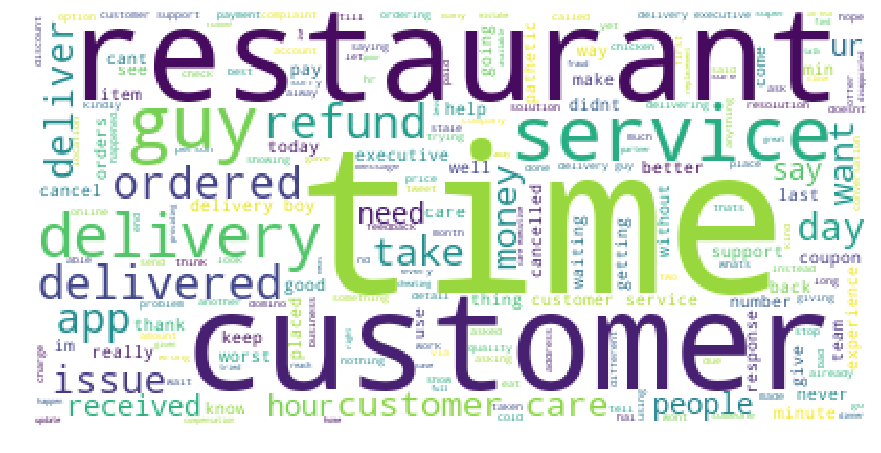

In [16]:
swiggy_corpus, swiggy_word_tokens = clean_corpus(swiggy_corpus)
cloud = WordCloud(background_color="white").generate(swiggy_corpus)

plt.figure(figsize=(15,15))
plt.imshow(cloud)

plt.axis('off')
plt.show()

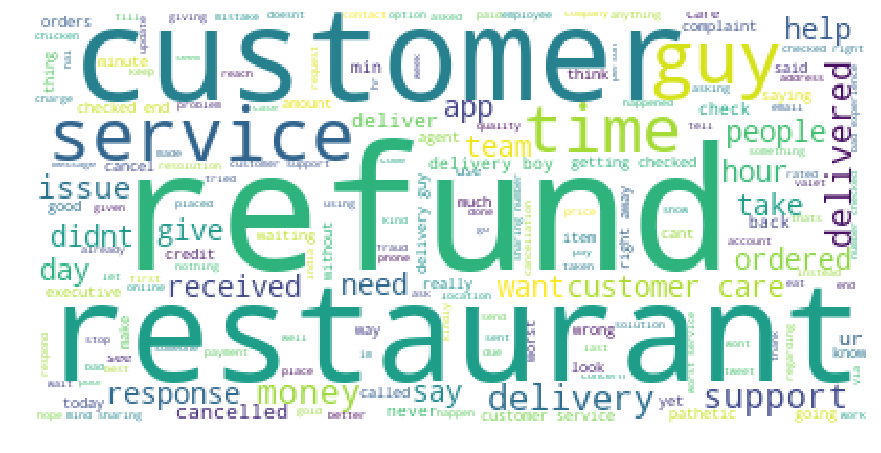

In [17]:
zomato_corpus, zomato_word_tokens = clean_corpus(zomato_corpus)
cloud = WordCloud(background_color="white").generate(zomato_corpus)

plt.figure(figsize=(15,15))
plt.imshow(cloud)

plt.axis('off')
plt.show()

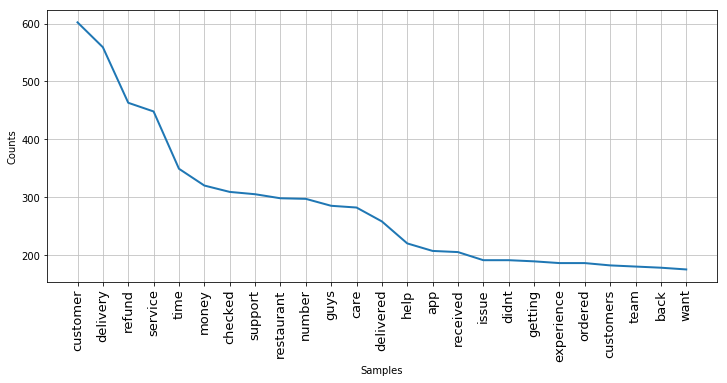

In [18]:
# all_words = []
# for line in list(df['full_text']):
#     words = line.split()
#     for word in words:
#         all_words.append(word.lower())# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(zomato_word_tokens)
fd.plot(25,cumulative=False)# log-log of all words 
# word_counts = sorted(Counter(word_tokens).values(), reverse=True)
# plt.figure(figsize=(12,5))
# plt.loglog(word_counts, linestyle='-', linewidth=1.5)
# plt.ylabel("Freq")
# plt.xlabel("Word Rank")

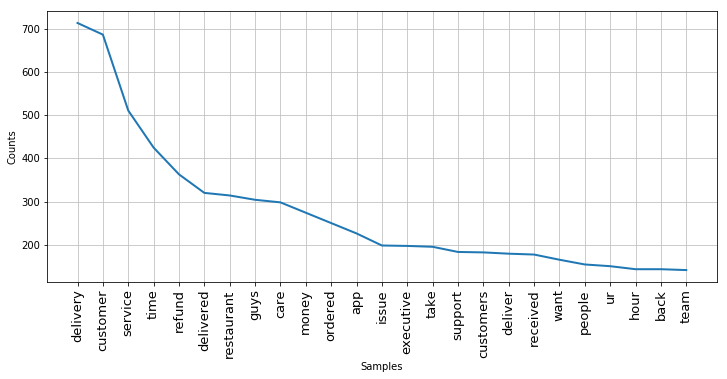

In [19]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(swiggy_word_tokens)
fd.plot(25,cumulative=False)# log-log of all words 